In [5]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [11]:
# Loading in our news data and robinhood data
# PLEASE MAKE SURE YOUR HEADLINES AND SENTIMENT CSV IS THE MOST RECENT VERSION
news_data = pd.read_csv('headlines_and_sentiment.csv')
robinhood_data = pd.read_csv('closing_popularity.csv')

In [12]:
news_data['date'] = [datetime.utcfromtimestamp(int(time) - 3 * 60 * 60).strftime('%Y-%m-%d') for time in news_data['datetime'].values]

In [13]:
news_data.head()

,Unnamed: 0,datetime,headline,stock,source,summary,neg,neu,pos,compound,date
0,0,1579046400,Implied Volatility Surging for Catalyst (CPRX)...,CPRX,Zacks,NaN,0.000,1.000,0.000,0.0000,2020-01-14
1,1,1579805117,These unfair tax policies are putting a burden...,CPRX,https://business.financialpost.com,Ted Rechtshaffen: Some political titan needs t...,0.286,0.714,0.000,-0.7184,2020-01-23
2,2,1580505387,"With four houses worth $2.5 million, this Onta...",CPRX,https://business.financialpost.com,Real estate investing has been good to Oscar a...,0.105,0.800,0.095,-0.0516,2020-01-31
3,3,1580860800,Shares of several healthcare and biotech compa...,CPRX,Benzinga Newsdesk,NaN,0.082,0.754,0.164,0.5719,2020-02-04
4,4,1580821330,Catalyst Pharmaceuticals Appoints David Ailing...,CPRX,Yahoo,"Catalyst Pharmaceuticals, Inc. (Catalyst) (CPR...",0.000,1.000,0.000,0.0000,2020-02-04


In [15]:
# Companies we care about
companies = ['CPRX', 'BABA', 'SNE', 'APHA', 'GOOGL', 'MSFT', 'AMZN', 'NRZ', 'PTON', 'PYPL', 'NKE', 'V', 
             'UBER', 'GM', 'FB', 'KO', 'MRNA', 'NVDA', 'PLUG', 'TXMD', 'ZNGA', 'WMT', 'JNJ', 'NTDOY', 
             'DKNG', 'ET', 'PENN', 'GE', 'JPM', 'DIS']

# All dates we have data for in string format
dates = pd.date_range(start="2020-01-15",end="2020-08-15")
dates = [date.strftime('%Y-%m-%d') for date in list(dates)]

In [16]:
# Calculating the smoothed sentiment scores for each date in the data and placing in a pandas dataframe
# The smoothed score is the sum of the means of the last 7 days of data over a window
smoothed_scores = {}
smoothed_scores['stock'] = []
smoothed_scores['score'] = []
smoothed_scores['date'] = []

window = 7
for company in companies:
    print(company)
    company_data = news_data[news_data['stock'] == company]
    smoothed_scores['stock'] += [company] * (len(dates) - window - 1)
    for i in range(len(dates) - window - 1):
        smoothed_scores['date'].append(dates[i + window - 1])
        score = 0
        for date in dates[i:i + window]:
            s = news_data[news_data['date'] == date]['compound']
            if len(s):
                score += s.mean()
        smoothed_scores['score'].append(score)


CPRX
BABA
SNE
APHA
GOOGL
MSFT
AMZN
NRZ
PTON
PYPL
NKE
V
UBER
GM
FB
KO
MRNA
NVDA
PLUG
TXMD
ZNGA
WMT
JNJ
NTDOY
DKNG
ET
PENN
GE
JPM
DIS


In [17]:
smoothed_scores_df = pd.DataFrame.from_dict(smoothed_scores)
smoothed_scores_df.head()

,stock,score,date
0,CPRX,0.529100,2020-01-21
1,CPRX,0.480924,2020-01-22
2,CPRX,0.460912,2020-01-23
3,CPRX,0.463959,2020-01-24
4,CPRX,0.415671,2020-01-25


In [18]:
# Calculating the mean sentiment scores of each date and placing in a pandas dataframe 
# (the mean of all the sentiment scores for a given date)
mean_scores = {}
mean_scores['stock'] = []
mean_scores['score'] = []
mean_scores['date'] = []

for company in companies:
    print(company)
    company_data = news_data[news_data['stock'] == company]
    mean_scores['stock'] += [company] * len(dates)
    for date in dates:
        mean_scores['date'].append(date)
        s = news_data[news_data['date'] == date]['compound']
        if len(s):
            mean_scores['score'].append(s.mean())
        else:
            mean_scores['score'].append(0)

CPRX
BABA
SNE
APHA
GOOGL
MSFT
AMZN
NRZ
PTON
PYPL
NKE
V
UBER
GM
FB
KO
MRNA
NVDA
PLUG
TXMD
ZNGA
WMT
JNJ
NTDOY
DKNG
ET
PENN
GE
JPM
DIS


In [19]:
mean_scores_df = pd.DataFrame.from_dict(mean_scores)
mean_scores_df.head()

,stock,score,date
0,CPRX,0.131602,2020-01-15
1,CPRX,0.087647,2020-01-16
2,CPRX,0.063207,2020-01-17
3,CPRX,0.072190,2020-01-18
4,CPRX,0.079172,2020-01-19


In [ ]:
# Fitting our OLS model and graphing/saving graph to data folder
# Setting our window for using our mean scores as predictors
window = 7

# Iterating through our companies
for company in companies:
    # Creating our x and y arrays/lists
    y = [robinhood_data[robinhood_data['date'] == date][company].values for date in dates[6 +  window - 1:-2]]
    x = []
    
    # adding our 7 predictors into the x array
    for i in range(len(dates[6:-2]) - window + 1):
        x.append([])
        # Iterating through our window and adding the mean
        for date in dates[6:-2][i:i + window]:
            s = news_data[news_data['date'] == date]['compound']
            if len(s):
                x[-1].append(s.sum())
            else:
                x.append(0)
    
    # Fitting our model
    x = sm.add_constant(x) # adding a constant
    model = sm.OLS(y, x) # fitting OLS
    results = model.fit()
    print(results.summary()) # Printing a summary of our model
    
    # Plotting our predicted popularity vs actual popularity over time
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(list(range(len(dates[6 +  window - 1:-2]))), y, 'o', label="data")
    ax.plot(list(range(len(dates[6 +  window - 1:-2]))), results.fittedvalues, 'r--.', label="OLS")
    plt.xlabel('Days Since January 27th, 2020')
    plt.ylabel('Popularity Count')
    plt.title(company + ' Actual vs Predictions')
    plt.savefig('./graphs/' + company + '.png')

Text(0.5, 1.0, 'Distribution of Sentiment Scores From Financial Headlines')

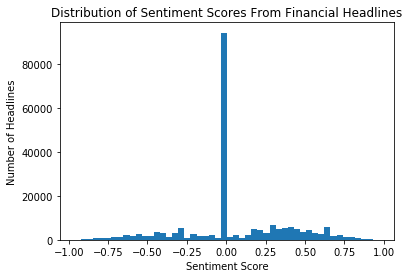

In [51]:
# Plotting the distribution of sentiment scores
plt.hist(news_data['compound'].values, bins = 50)
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Headlines')
plt.title('Distribution of Sentiment Scores From Financial Headlines')